In [2]:
import nashpy as nash
import numpy as np
from typing import Tuple

NUM_EVENTS = 3
NUM_SIGNALS = 3

def generate_matrices_one_to_one(prob_distribution: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """ prob_distribution: 1 x NUM_EVENTS
        signal_costs: 1 x NUM_SIGNALS
        sender_matrix: NUM_EVENTS x NUM_SIGNALS
        receiver_matrix: NUM_SIGNALS x NUM_EVENTS
    """
    base_sender_matrix = np.zeros((NUM_EVENTS, NUM_SIGNALS))
    np.fill_diagonal(base_sender_matrix, 1)
    sender_matrix =  (base_sender_matrix.T * prob_distribution).T
    
    receiver_matrix = np.zeros((NUM_SIGNALS, NUM_EVENTS))
    np.fill_diagonal(receiver_matrix, 1)
    
    return sender_matrix, receiver_matrix

def payoff(sender_matrix: np.ndarray, receiver_matrix: np.ndarray, signal_costs: np.ndarray) -> float:
    """ sender_matrix: NUM_EVENTS x NUM_SIGNALS
        receiver_matrix: NUM_SIGNALS x NUM_EVENTS
        signal_costs: 1 x NUM_SIGNALS
    """
    return np.trace(np.matmul(sender_matrix, receiver_matrix/signal_costs))

probs = [0.8, 0.1, 0.1]
costs = [5, 1, 1]
s, r = generate_matrices_one_to_one(probs)
payoff(s, r, costs)
    

0.36

In [80]:
# 2d experiment
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint

# s_ij - the probability of the sender mapping event i to signal j
# e_ji - the probability of the receiver mapping signal j to event i

# vector: x = [s_11, s_12, s_21, s_22, e_11, e_21, e_12, e_22]
GAME_SIZE = 2
PROB_VECTOR = [0.99, 0.1]
COST_VECTOR = [10, 1]
# "global" for diff_evolution, "local" to find one min
OPT_TYPE = "global"
results = []


# note this library works on minimization problems, so I write the negative of the true objective
def objective(x: np.ndarray) -> float:
    results.append(x)
    return -1 * (PROB_VECTOR[0] * (1/COST_VECTOR[0]) * (x[0] * x[4]) + PROB_VECTOR[0] * (1/COST_VECTOR[1]) * (x[1] * x[6]) + \
PROB_VECTOR[1] * (1/COST_VECTOR[0]) * (x[2] * x[5]) + PROB_VECTOR[1] * (1/COST_VECTOR[1]) * (x[3] * x[7]))

# s_11 + s_12 = 1
def constraint_1(x: np.ndarray) -> float:
    return x[0] + x[1] - 1

# s_21 + s_22 = 1
def constraint_2(x: np.ndarray) -> float:
    return x[2] + x[3] - 1

# e_11 + e_21 = 1
def constraint_3(x: np.ndarray) -> float:
    return x[4] + x[5] - 1

# e_12 + e_22
def constraint_4(x: np.ndarray) -> float:
    return x[6] + x[7] - 1

if OPT_TYPE == "local":
    all_constraints = ([{"type": "eq", "fun": constraint_1},{"type": "eq", "fun": constraint_2}, {"type": "eq", "fun": constraint_3},
                       {"type": "eq", "fun": constraint_4}])
    x0 = np.random.uniform(low=0, high=1, size=(8,))
    b = (0, 1)
    bounds = tuple([b] * 8)
    solution = minimize(objective,x0,method='SLSQP',\
                        bounds=bounds,constraints=all_constraints)
    x = solution.x
    print(x)

    print('Final SSE Objective: ' + str(objective(x)))

elif OPT_TYPE == "global":
    constraints = ( NonlinearConstraint(constraint_1, 0, 0),
                   NonlinearConstraint(constraint_2, 0, 0),
                   NonlinearConstraint(constraint_3, 0, 0),
                   NonlinearConstraint(constraint_4, 0, 0),
                  )
    b = (0, 1)
    bounds = tuple([b] * 8)
    
    solution = differential_evolution(objective,bounds=bounds,maxiter=100000,constraints=constraints)
    print("succeeded? ", solution.success)

    print(solution)
    sender_solution, receiver_solution = vector_to_matrices(solution.x)
    print(sender_solution)
    print(receiver_solution)
    

/root/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


succeeded?  False
           constr: [array([0.]), array([1.11022302e-16]), array([0.]), array([0.])]
 constr_violation: 1.1102230246251565e-16
              fun: -0.9999679464302927
              jac: [array([[1., 1., 0., 0., 0., 0., 0., 0.]]), array([[0.        , 0.        , 1.00000001, 1.00000001, 0.        ,
        0.        , 0.        , 0.        ]]), array([[0., 0., 0., 0., 1., 1., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 1., 1.]]), array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])]
            maxcv: 1.1102230246251565e-16
          message: 'The solution does not satisfy the constraints, MAXCV = '
             nfev: 2596
              nit: 7120
          success: False
                x: array([8.644

In [35]:
sender = np.array([[0.5, 0], [0, 0.5]])
receiver = np.array([[1, 0], [0, 1]])
print(payoff(sender, receiver, COST_VECTOR))

0.55


In [9]:
# 2d experiment
from scipy.optimize import minimize, differential_evolution, NonlinearConstraint
from typing import Callable, List
import pdb
# s_ij - the probability of the sender mapping event i to signal j
# e_ji - the probability of the receiver mapping signal j to event i

# x is of size 2n^2 and enumerates entries as [p: 11, 12, ... 1n, 21....nn, q: same]
GAME_SIZE = 3
# "global" for diff_evolution, "local" to find one min
OPT_TYPE = "global"
PROB_VECTOR = [0.33, 0.33, 0.33]
COST_VECTOR = [1, 1, 1]

test = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
flat_test = list(test.flatten())
flat_test.extend(flat_test)

results = []

def make_objective_size_n(n: int) -> Callable:
    def objective(x: List) -> float:
        sender_matrix = np.array(x[:len(x)//2]).reshape(n, n)
        receiver_matrix = np.array(x[len(x)//2:]).reshape(n, n)
        prob_and_sender = (sender_matrix.T * PROB_VECTOR).T
        cost_and_receiver = (receiver_matrix.T / COST_VECTOR).T
        results.append(x)
        
        return -np.trace(np.matmul(sender_matrix, receiver_matrix))
    
    return objective
    
def make_2n_constraints(n: int) -> tuple:
    constraints = []

    for i in range(n):
        con_s = lambda x: sum([x[j] for j in range(i * n, i * n + n)]) - 1
        con_r = lambda x: sum([x[n ** 2 + j] for j in range(i * n, i * n + n)]) - 1
        if OPT_TYPE == "local":
            constraints.append({"type": "eq", "fun": con_s})
            constraints.append({"type": "eq", "fun": con_r})
        else:
            constraints.append(NonlinearConstraint(con_s, 0, 0))
            constraints.append(NonlinearConstraint(con_r, 0, 0))

    return tuple(constraints)

def vector_to_matrices(x: List) -> Tuple[np.ndarray, np.ndarray]:
    sender_half = x[:len(x)//2]
    receiver_half = x[len(x)//2:]
    
    return np.array(sender_half).reshape(GAME_SIZE, GAME_SIZE), np.array(receiver_half).reshape(GAME_SIZE, GAME_SIZE)

constraints = make_2n_constraints(GAME_SIZE)
objective = make_objective_size_n(GAME_SIZE)

b = (0, 1)
bounds = tuple([b] * 2 * GAME_SIZE ** 2)

if OPT_TYPE == "local":
    x0 = np.random.uniform(low=0, high=1, size=(2 * GAME_SIZE ** 2,))
    solution = minimize(objective,x0,method='SLSQP',\
                        bounds=bounds,constraints=constraints)
    x = solution.x
    print(vector_to_matrices(x))

    print('Final SSE Objective: ' + str(objective(x)))

else:
    solution = differential_evolution(objective,bounds=bounds,maxiter=1000000,constraints=constraints)
    sender_soln, receiver_soln = vector_to_matrices(solution.x)
    print(sender_soln)
    print(receiver_soln)



/root/anaconda3/lib/python3.8/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +
/root/anaconda3/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[[9.92989487e-01 9.96579313e-01 9.96646602e-01]
 [9.90053908e-01 9.94617870e-01 9.69382178e-01]
 [1.09052496e-02 9.88929630e-01 1.65120114e-04]]
[[0.99624118 0.99796709 0.96645691]
 [0.99268499 0.99697532 0.99734418]
 [0.69815811 0.2937928  0.00804909]]


       state_1->signal_1  state_1->signal_2  state_1->signal_3  \
0               0.043968           0.591539           0.133685   
1               0.423652           0.526560           0.392490   
2               0.229372           0.446056           0.572186   
3               0.319523           0.693203           0.787898   
4               0.114535           0.653532           0.095665   
...                  ...                ...                ...   
23716           0.920905           0.955977           0.925040   
23717           0.920905           0.955977           0.925040   
23718           0.920905           0.955977           0.925040   
23719           0.920905           0.955977           0.925040   
23720           0.920905           0.955977           0.925040   

       state_2->signal_1  state_2->signal_2  state_2->signal_3  \
0               0.697191           0.451259           0.891210   
1               0.854089           0.568236           0.429123   
2        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


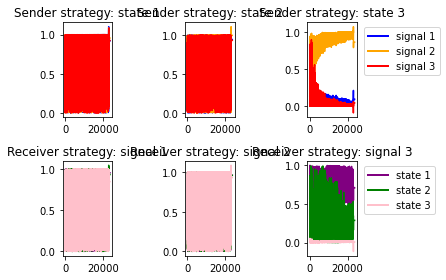

In [11]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pandas as pd
import seaborn as sns

# simulations:
# 1. equal probabilities, equal costs [x]
# 2. equal probabilities, 10fold difference in costs [x]
# 3. equal probabilities, 50fold difference in costs [x]
# 4. unequal probabilities (80/20?), equal costs [x]
# 5. unequal probabilities (90/10), equal costs [x]
# 6. unequal probabilities (99/1), equal costs [x]
# 7. unequal probabilities (80/20), unequal costs (1/10) [x]
# 8. unequal probabilities (90/10), unequal costs (1/10) [x]
# 9. unequal probabilities (99/1), unequal costs (1/10) [didn't converge]

# 3.1: [didn't converge]

def show_evolution_over_time(df: pd.DataFrame) -> None:
    fig, axs = plt.subplots(ncols=2, nrows=2)

    state_lines = [Line2D([0], [0], color="blue", lw=2),
                Line2D([0], [0], color="orange", lw=2)]
    signal_lines = [Line2D([0], [0], color="purple", lw=2),
                Line2D([0], [0], color="green", lw=2)]
    
    sns.lineplot(data=df["state_1->signal_1"], dashes=False, ax=axs[0,0], color="blue")
    sns.lineplot(data=df["state_1->signal_2"], dashes=False, ax=axs[0,0], color="orange")
    axs[0,0].set_title("Sender strategy: state 1")
    
    sns.lineplot(data=df["state_2->signal_1"], dashes=False, ax=axs[0, 1], color="blue")
    sns.lineplot(data=df["state_2->signal_2"], dashes=False, ax=axs[0, 1], color="orange")
    axs[0,1].legend(state_lines, ["signal 1", "signal 2"], bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[0,1].set_title("Sender strategy: state 2")

    sns.lineplot(data=df["signal_1->state_1"], dashes=False, ax=axs[1,0], color="purple")
    sns.lineplot(data=df["signal_1->state_2"], dashes=False, ax=axs[1,0], color="green")
    axs[1, 0].set_title("Receiver strategy: signal 1")
    
    sns.lineplot(data=df["signal_2->state_1"], dashes=False, ax=axs[1, 1], color="purple")
    sns.lineplot(data=df["signal_2->state_2"], dashes=False, ax=axs[1, 1], color="green")
    axs[1,1].legend(signal_lines, ["state 1", "state 2"], bbox_to_anchor=(1.05, 1), loc='upper left')

    axs[1, 1].set_title("Receiver strategy: signal 2")
    
    plt.tight_layout()
    plt.savefig("trial_3_1.eps")
    plt.savefig("trial_3_1.png")
    
def show_evolution_over_time_3_by_3(df: pd.DataFrame) -> None:
    fig, axs= plt.subplots(ncols=3, nrows=2)
    state_lines = [Line2D([0], [0], color="blue", lw=2),
                Line2D([0], [0], color="orange", lw=2),
                  Line2D([0], [0], color="red", lw=2)]
    signal_lines = [Line2D([0], [0], color="purple", lw=2),
                Line2D([0], [0], color="green", lw=2),
                   Line2D([0], [0], color="pink", lw=2)]
    
    sns.lineplot(data=df["state_1->signal_1"], dashes=False, ax=axs[0,0], color="blue")
    sns.lineplot(data=df["state_1->signal_2"], dashes=False, ax=axs[0,0], color="orange")
    sns.lineplot(data=df["state_1->signal_3"], dashes=False, ax=axs[0,0], color="red")
    axs[0,0].set_title("Sender strategy: state 1")
    
    sns.lineplot(data=df["state_2->signal_1"], dashes=False, ax=axs[0, 1], color="blue")
    sns.lineplot(data=df["state_2->signal_2"], dashes=False, ax=axs[0, 1], color="orange")
    sns.lineplot(data=df["state_2->signal_3"], dashes=False, ax=axs[0, 1], color="red")
    axs[0,1].set_title("Sender strategy: state 2")

    sns.lineplot(data=df["state_3->signal_1"], dashes=False, ax=axs[0, 2], color="blue")
    sns.lineplot(data=df["state_3->signal_2"], dashes=False, ax=axs[0, 2], color="orange")
    sns.lineplot(data=df["state_3->signal_3"], dashes=False, ax=axs[0, 2], color="red")
    axs[0,2].legend(state_lines, ["signal 1", "signal 2", "signal 3"], bbox_to_anchor=(1.05, 1), loc='upper left')
    axs[0,2].set_title("Sender strategy: state 3")
    
    sns.lineplot(data=df["signal_1->state_1"], dashes=False, ax=axs[1,0], color="purple")
    sns.lineplot(data=df["signal_1->state_2"], dashes=False, ax=axs[1,0], color="green")
    sns.lineplot(data=df["signal_1->state_3"], dashes=False, ax=axs[1,0], color="pink")
    axs[1, 0].set_title("Receiver strategy: signal 1")
    
    sns.lineplot(data=df["signal_2->state_1"], dashes=False, ax=axs[1, 1], color="purple")
    sns.lineplot(data=df["signal_2->state_2"], dashes=False, ax=axs[1, 1], color="green")
    sns.lineplot(data=df["signal_2->state_3"], dashes=False, ax=axs[1, 1], color="pink")
    axs[1, 1].set_title("Receiver strategy: signal 2")
    
    sns.lineplot(data=df["signal_3->state_1"], dashes=False, ax=axs[1, 2], color="purple")
    sns.lineplot(data=df["signal_3->state_2"], dashes=False, ax=axs[1, 2], color="green")
    sns.lineplot(data=df["signal_3->state_3"], dashes=False, ax=axs[1, 2], color="pink")
    axs[1,2].set_title("Receiver strategy: signal 3")
    axs[1,2].legend(signal_lines, ["state 1", "state 2", "state 3"], bbox_to_anchor=(1.05, 1), loc='upper left')

    
    plt.tight_layout()
    plt.savefig("trial_3_1.eps")
    plt.savefig("trial_3_1.png")
  
if GAME_SIZE == 2:
    df = pd.DataFrame(results, columns=["state_1->signal_1", "state_1->signal_2", "state_2->signal_1", "state_2->signal_2", 
                                       "signal_1->state_1", "signal_1->state_2", "signal_2->state_1", "signal_2->state_2"])
elif GAME_SIZE == 3:
    df = pd.DataFrame(results, columns=["state_1->signal_1", "state_1->signal_2", "state_1->signal_3", "state_2->signal_1", "state_2->signal_2",
                                        "state_2->signal_3", "state_3->signal_1", "state_3->signal_2", "state_3->signal_3",
                                        "signal_1->state_1", "signal_1->state_2", "signal_1->state_3",
                                        "signal_2->state_1", "signal_2->state_2", "signal_2->state_3", "signal_3->state_1",
                                       "signal_3->state_2", "signal_3->state_3"])
df.to_csv("trial_3_1.csv", index=False)
print(df)

if GAME_SIZE == 2:
    show_evolution_over_time(df)
else:
    show_evolution_over_time_3_by_3(df)
    
    